In [60]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
df = pd.read_csv("data/penguins_size.csv")
df

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,FEMALE
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,MALE
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,FEMALE


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


### ペンギンのサイズと種別を記録したデータセット
- species - ペンギンの種類(chinstrap, Adelie, Gentoo)
- culmen_length_mm - くちばしの長さ(mm)
- culmen_depth_mm - くちばしの高さ(mm)
- flipper_length_mm - 翼の長さ(mm)
- body_mass_g - 体重(g)
- island - 調査した島(Dream, Torgersen, Biscoe) @ 南極大陸
- sex - 性別  
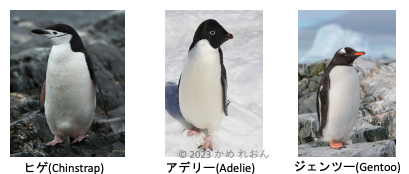

In [19]:
df.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


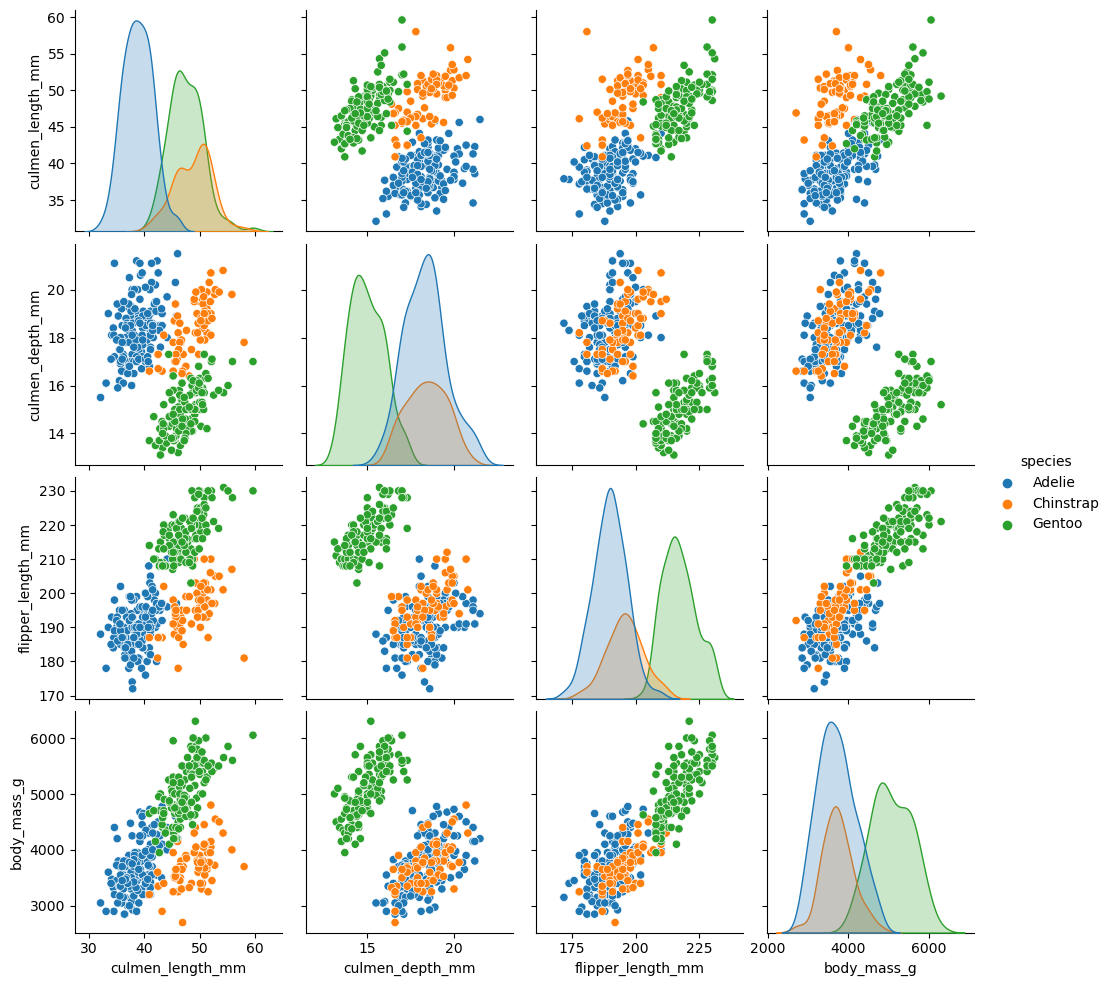

In [6]:
%matplotlib inline
sns.pairplot(df, hue="species")

#### 相関係数の確認

<AxesSubplot:>

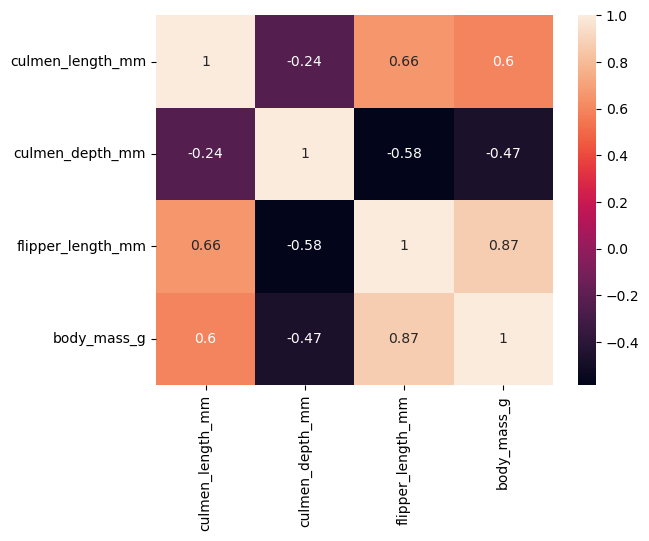

In [7]:
sns.heatmap(df.corr(), annot=True)

#### カテゴリカル変数の処理

In [22]:
cat_cols = df.select_dtypes(exclude=np.number).columns.to_list()
for cat_col in cat_cols:
    print(f"========{cat_col}=======")
    print(df[cat_col].value_counts())

========species=======
Adelie       152
Gentoo       124
Chinstrap     68
Name: species, dtype: int64
========island=======
Biscoe       168
Dream        124
Torgersen     52
Name: island, dtype: int64
========sex=======
MALE      168
FEMALE    165
Name: sex, dtype: int64


sexのカテゴリカル変数に "." という誤字が確認されていることがわかる！  
**=> 欠損値としてまとめて扱いやすくするように、np.nan を代入しておく**

In [21]:
df.loc[df[df["sex"] == "."].index, "sex"] = np.nan

それぞれの欠損地の扱いによる違いを比較するため、結果を格納するresultを用意しておく

In [46]:
results = {}

In [ ]:
df[df["sex"].isna()]

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN
246,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN
286,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN
324,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,NaN


3番目と339番目の行は、speciesとisland以外のデータがほとんどNaNであり、分析できないので先に`drop`しておく

In [35]:
drop_target_idx = df.index[df["sex"].isna() & df["body_mass_g"].isna() & df["flipper_length_mm"].isna()]
df.drop(drop_target_idx, axis=0, inplace=True)

## 1.欠損値を落とすケース

In [47]:
df = pd.read_csv("data/penguins_size.csv")
# "."は欠損値扱いにする
df.loc[df[df["sex"] == "."].index, "sex"] = np.nan

df.dropna(inplace=True)

# モデル構築
target = "species"
X = df.drop(target, axis=1)
y = df[target]

# 前処理
# ダミー変数
X = pd.get_dummies(X, drop_first=True)

# Cross Validation
k = 5
n_repeats = 3
cv = RepeatedKFold(n_splits=k, n_repeats=n_repeats, random_state=0)

# 標準化の処理とモデルの学習をまとめるためのパイプを利用する
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ("model", LogisticRegression())])

scores = cross_val_score(pipeline, X, y, cv = cv, scoring="neg_log_loss")
results["drop"] = -np.mean(scores)

## 2.欠損値を新カテゴリとするケース(数値カラムは中央値)

In [58]:
df = pd.read_csv("data/penguins_size.csv")
target = "species"
X = df.drop(target, axis=1)
y = df[target]

# "."は欠損値扱いにする
df.loc[df[df["sex"] == "."].index, "sex"] = np.nan

# Cross Validation---------------------------------------
k = 5
n_repeats = 3
cv = RepeatedKFold(n_splits=k, n_repeats=n_repeats, random_state=0)


# PipeLineに組み込むためのダミー変数生成クラスの自作--------------------
class GetDummies(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.columns = None
        
    def fit(self, X, y=None):
        self.columns = pd.get_dummies(X).columns
        return self
    
    def transform(self, X):
        X_new = pd.get_dummies(X)
        return X_new.reindex(columns=self.columns, fill_value=0)

# Columns Transformer (imputer)--------------------------
num_cols = X.select_dtypes(include=np.number).columns.to_list()
cat_cols = X.select_dtypes(exclude=np.number).columns.to_list()

ct = ColumnTransformer([
    ("imputer_cat", SimpleImputer(strategy="constant", fill_value="NaN"), cat_cols),
    ("imputer_num", SimpleImputer(strategy="median"), num_cols),
])
# デフォルトではnumpy arrayで返されるので、
# DataFrameで返されるように指定しておく
ct.set_output(transform="pandas")

ct.fit_transform(X)


# PipeLine(dummy + scaler + model)------------------------
pipeline = Pipeline(
    steps=[("ct", ct), ("dummy", GetDummies()), ("scaler", StandardScaler()), ("model", LogisticRegression())]
)


scores = cross_val_score(pipeline, X, y, cv=cv, scoring="neg_log_loss")
results["median"] = -np.mean(scores)


## 3.欠損値をkNNで予測するケース(カテゴリカルカラムは最頻値)

In [68]:
df = pd.read_csv("data/penguins_size.csv")
target = "species"
X = df.drop(target, axis=1)
y = df[target]

# "."は欠損値扱いにする
df.loc[df[df["sex"] == "."].index, "sex"] = np.nan

# Cross Validation---------------------------------------
k = 5
n_repeats = 3
cv = RepeatedKFold(n_splits=k, n_repeats=n_repeats, random_state=0)


# PipeLineに組み込むためのダミー変数生成クラスの自作--------------------
class GetDummies(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.columns = None
        
    def fit(self, X, y=None):
        self.columns = pd.get_dummies(X).columns
        return self
    
    def transform(self, X):
        X_new = pd.get_dummies(X)
        return X_new.reindex(columns=self.columns, fill_value=0)

# Columns Transformer (imputer)--------------------------
num_cols = X.select_dtypes(include=np.number).columns.to_list()
cat_cols = X.select_dtypes(exclude=np.number).columns.to_list()

ct = ColumnTransformer([
    ("imputer_cat", SimpleImputer(strategy="most_frequent"), cat_cols),
    # kNNを実行するために標準化しておく必要がある
    ("scaler+imputer_num", 
     Pipeline([
         ("scaler", StandardScaler()),
         ("imputer_num", KNNImputer())
     ]),
     num_cols
    )
])
# # デフォルトではnumpy arrayで返されるので、
# # DataFrameで返されるように指定しておく
ct.set_output(transform="pandas")
ct.fit_transform(X)


# # PipeLine(dummy + scaler + model)------------------------
pipeline = Pipeline(
    steps=[("ct", ct), ("dummy", GetDummies()), ("scaler", StandardScaler()), ("model", LogisticRegression())]
)


scores = cross_val_score(pipeline, X, y, cv=cv, scoring="neg_log_loss")
results["knn"] = -np.mean(scores)


In [69]:
results

{'drop': 0.029028473393478905,
 'median': 0.03293602891548595,
 'knn': 0.03182927518473786}